In [ ]:
pip install mplsoccer

In [ ]:
from urllib.request import urlopen
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from mplsoccer import Pitch, FontManager, add_image

**This is for Customizing the font**

In [ ]:
font_normal = FontManager(("https://github.com/google/fonts/blob/main/ofl/dosis/Dosis%5Bwght%5D.ttf?raw=true"))

#https://github.com/google/fonts/blob/main/ofl/dosis/Dosis%5Bwght%5D.ttf

In [ ]:
URL = 'https://fbref.com/en/share/dxjMn'
df = pd.read_html(URL)[0]
# select a subset of the columns (Squad and pressure columns)
df = df[['Unnamed: 0_level_0', 'Pressures']].copy()
df.columns = df.columns.droplevel() # drop the top-level of the multi-index

Get the league average percentages

In [ ]:
pressure_cols = ['Def 3rd', 'Mid 3rd', 'Att 3rd']
df_total = pd.DataFrame(df[pressure_cols].sum())
df_total.columns = ['total']
df_total = df_total.T
df_total = df_total.divide(df_total.sum(axis=1), axis=0) * 100

Calculate the percentages for each team and sort so that the teams which press higher are last

In [ ]:
df[pressure_cols] = df[pressure_cols].divide(df[pressure_cols].sum(axis=1), axis=0) *100.
df.sort_values(['Att 3rd', 'Def 3rd'], ascending=[True, False], inplace=True)

# Get the StatsBomb logo and Fonts

In [ ]:
LOGO_URL = 'https://raw.githubusercontent.com/statsbomb/open-data/master/img/statsbomb-logo.jpg'
sb_logo = Image.open(urlopen(LOGO_URL))
# a FontManager object for using a google font (default Robotto)
#fm = FontManager()
fm = font_normal # i added my own font DOSIS
# path effects
path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
path_effects.Normal()]


# Plot the percentages

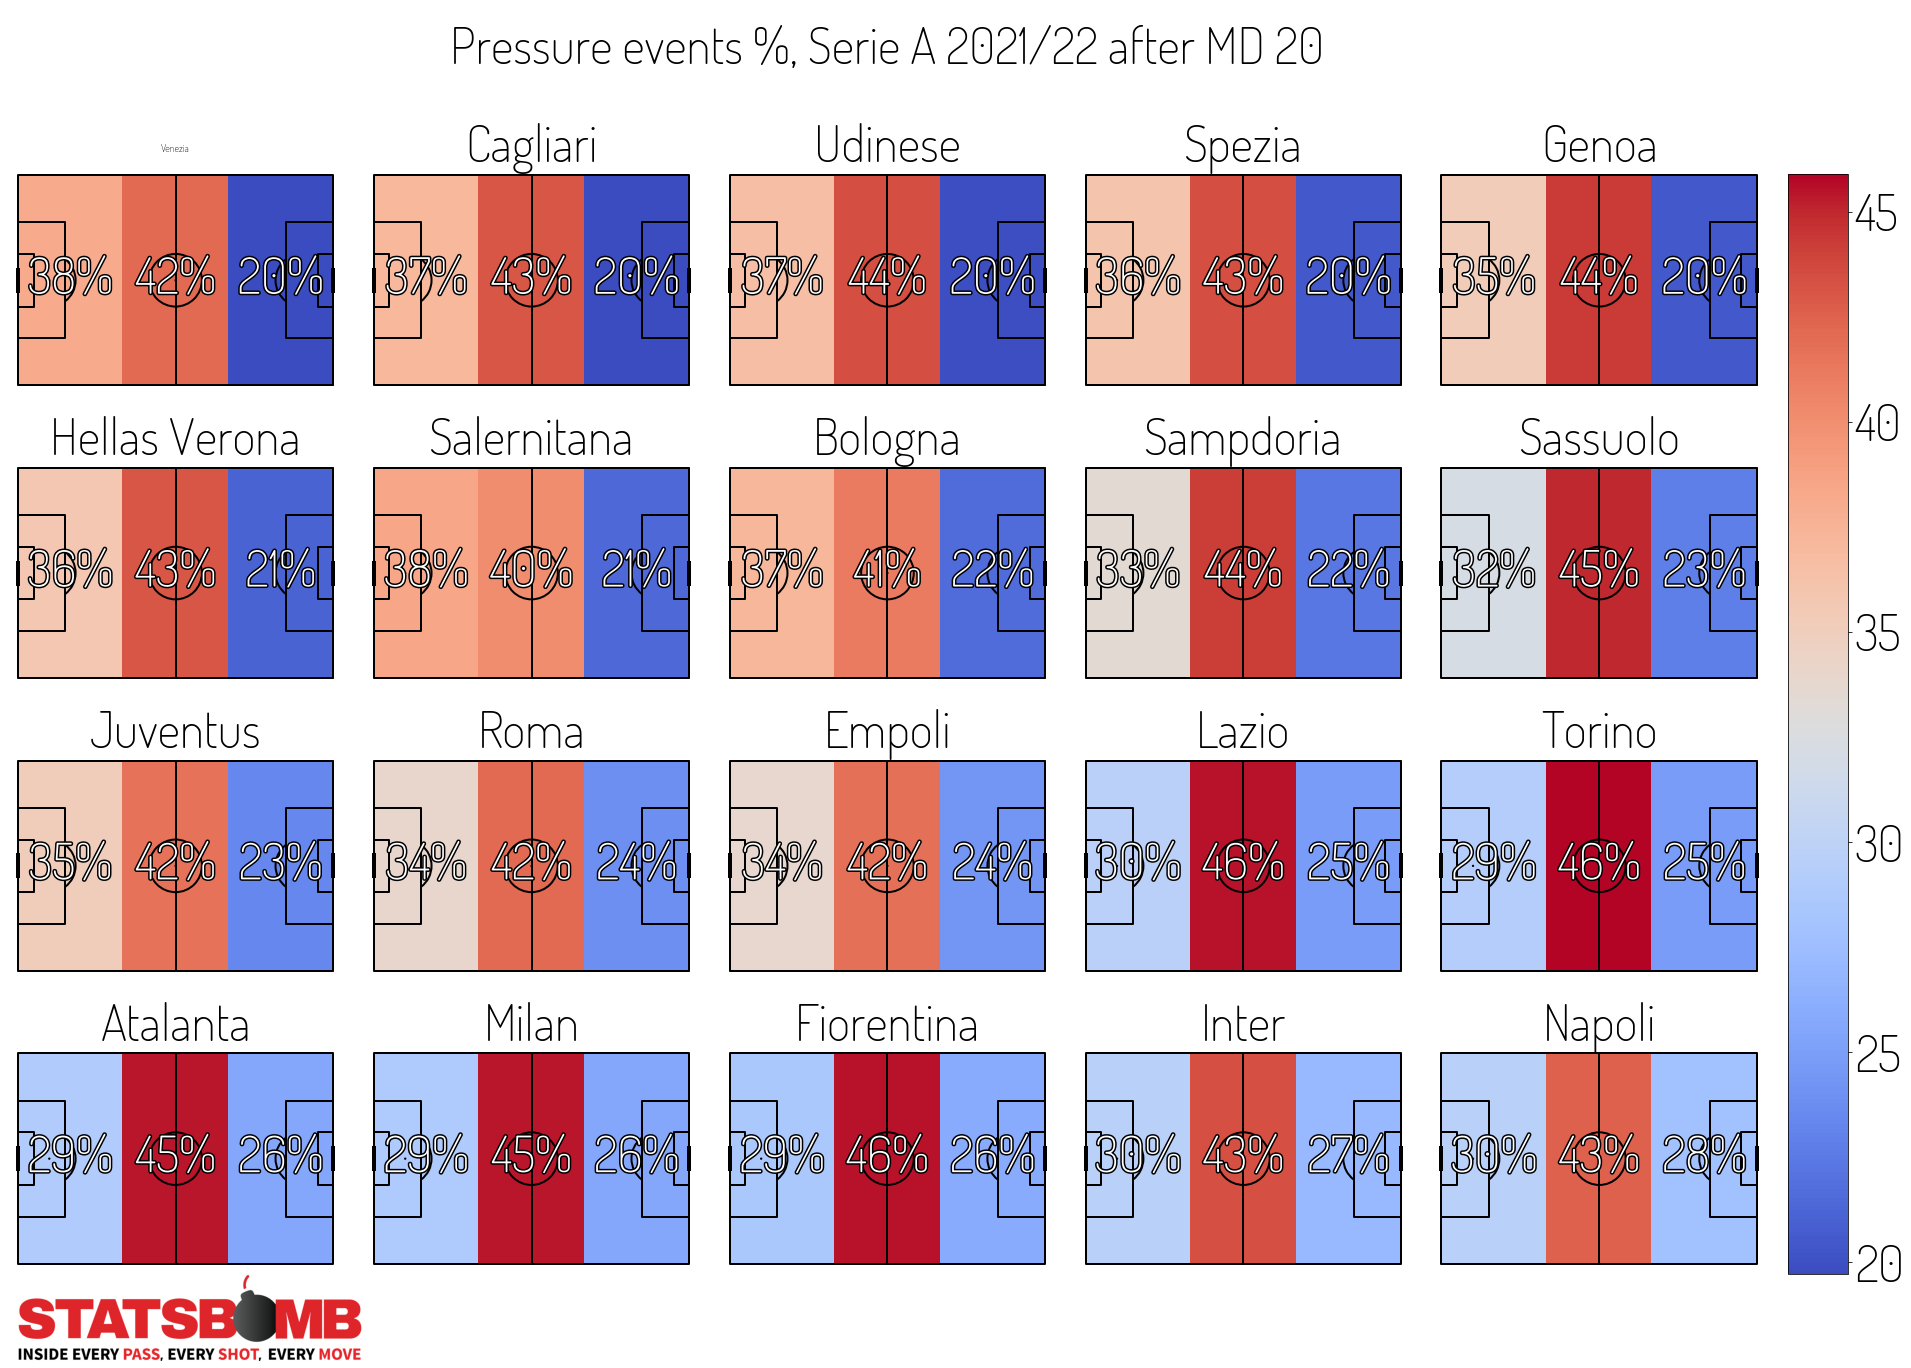

In [ ]:
# setup a mplsoccer pitch
pitch = Pitch(line_zorder=2, line_color='black', pad_top=20)
# mplsoccer calculates the binned statistics usually from raw locations, such as pressure events
# for this example we will create a binned statistic dividing
# the pitch into thirds for one point (0, 0)
# we will fill this in a loop later with each team's statistics from the dataframe
bin_statistic = pitch.bin_statistic([0], [0], statistic='count', bins=(3, 1))
GRID_HEIGHT = 0.8
CBAR_WIDTH = 0.03
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=20,
# leaves some space on the right hand side for the colorbar
                      grid_width=0.88, left=0.025,
                      endnote_height=0.06, endnote_space=0,
# Turn off the endnote/title axis. I usually do this after
# I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=GRID_HEIGHT)

fig.set_facecolor('white')

teams = df['Squad'].values
vmin = df[pressure_cols].min().min() # we normalise the heatmaps with the min / max values
vmax = df[pressure_cols].max().max()
for i, ax in enumerate(axs['pitch'].flat[:len(teams)]):
  # the top of the StatsBomb pitch is zero
  # plot the title half way between zero and -20 (the top padding)
  ax.text(60, -10, teams[i], ha='center', va='center', fontsize=50, fontproperties=fm.prop)
  # fill in the bin statistics from df and plot the heatmap
  bin_statistic['statistic'] = df.loc[df.Squad == teams[i], pressure_cols].values
  heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin,vmax=vmax)
  annotate = pitch.label_heatmap(bin_statistic, color='white', fontproperties=fm.prop,
                                 path_effects=path_eff, fontsize=50, ax=ax,
                                 str_format='{0:.0f}%', ha='center', va='center')
# if its the Bundesliga remove the two spare pitches
#if len(teams) == 20:
 # for ax in axs['pitch'][-1, 3:]:
  #  ax.remove()
# add cbar axes
cbar_bottom = axs['pitch'][-1, 0].get_position().y0
cbar_left = axs['pitch'][0, -1].get_position().x1 + 0.01
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, CBAR_WIDTH,
  # take a little bit off the height because of padding
  GRID_HEIGHT - 0.036))
cbar = plt.colorbar(heatmap, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(fm.prop)
    label.set_fontsize(50)
# title and endnote
add_image(sb_logo, fig,
          left=axs['endnote'].get_position().x0,
          bottom=axs['endnote'].get_position().y0,
          height=axs['endnote'].get_position().height)
title = axs['title'].text(0.5, 0.5, 'Pressure events %, Serie A 2021/22 after MD 20',
                          ha='center', va='center', fontsize=70, fontproperties=fm.prop)


# Plot the percentage point difference

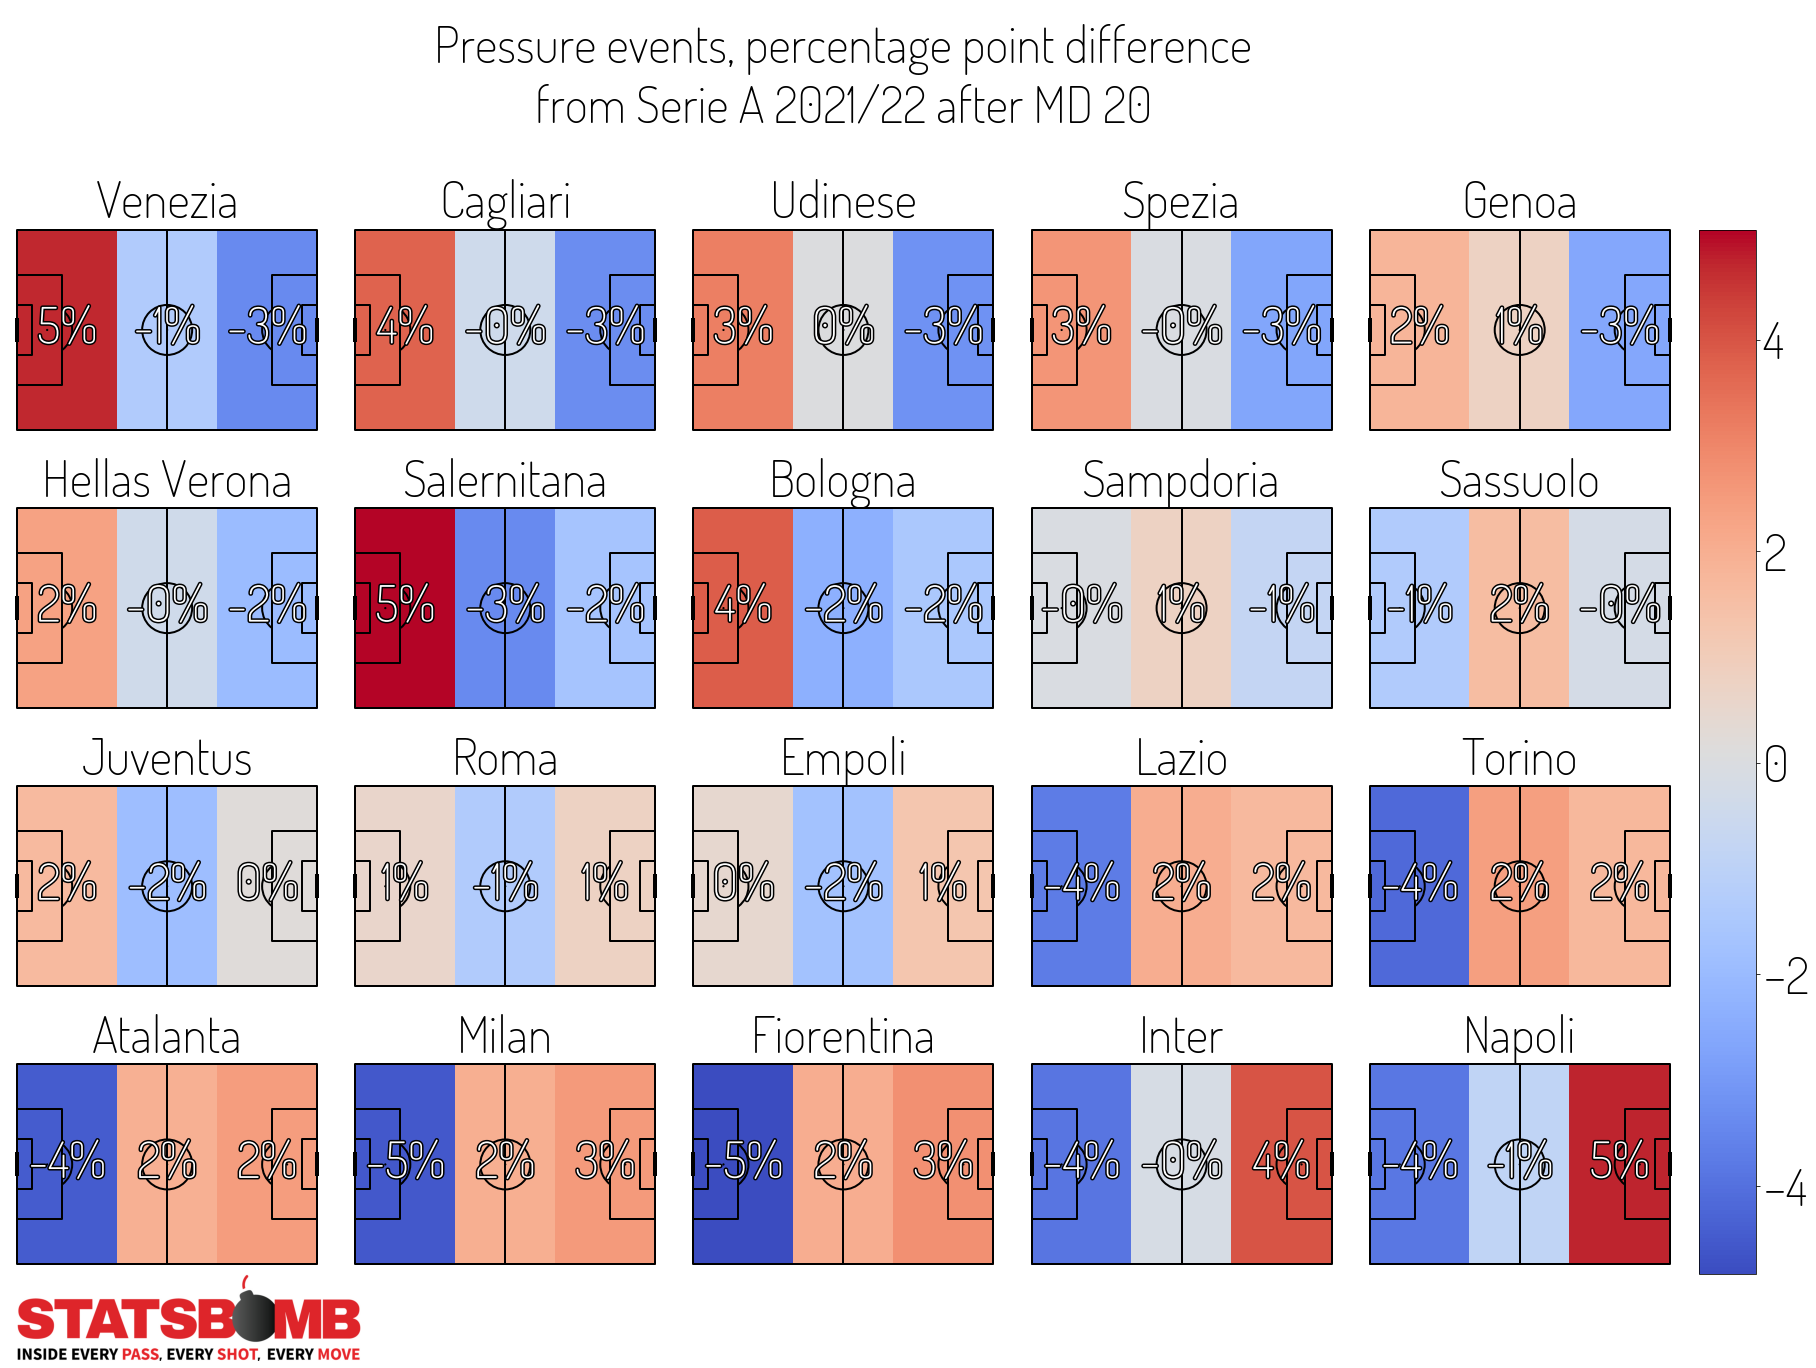

In [ ]:
# Calculate the percentage point difference from the league average
df[pressure_cols] = df[pressure_cols].values - df_total.values

GRID_HEIGHT = 0.76
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=20,
                      # leaves some space on the right hand side for the colorbar
                      grid_width=0.88, left=0.025,
                      endnote_height=0.06, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0.02, title_height=0.1, grid_height=GRID_HEIGHT)
fig.set_facecolor('white')

teams = df['Squad'].values
vmin = df[pressure_cols].min().min()  # we normalise the heatmaps with the min / max values
vmax = df[pressure_cols].max().max()

for i, ax in enumerate(axs['pitch'].flat[:len(teams)]):
    # the top of the StatsBomb pitch is zero
    # plot the title half way between zero and -20 (the top padding)
    ax.text(60, -10, teams[i], ha='center', va='center', fontsize=50, fontproperties=fm.prop)

    # fill in the bin statistics from df and plot the heatmap
    bin_statistic['statistic'] = df.loc[df.Squad == teams[i], pressure_cols].values
    heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin, vmax=vmax)
    annotate = pitch.label_heatmap(bin_statistic, color='white', fontproperties=fm.prop,
                                   path_effects=path_eff, str_format='{0:.0f}%', fontsize=50,
                                   ax=ax, ha='center', va='center')

# if its the Bundesliga remove the two spare pitches
if len(teams) == 18:
    for ax in axs['pitch'][-1, 3:]:
        ax.remove()

# add cbar axes
cbar_bottom = axs['pitch'][-1, 0].get_position().y0
cbar_left = axs['pitch'][0, -1].get_position().x1 + 0.01
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, CBAR_WIDTH,
                        # take a little bit off the height because of padding
                        GRID_HEIGHT - 0.035))
cbar = plt.colorbar(heatmap, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(fm.prop)
    label.set_fontsize(50)

# title and endnote
add_image(sb_logo, fig,
          left=axs['endnote'].get_position().x0,
          bottom=axs['endnote'].get_position().y0,
          height=axs['endnote'].get_position().height)
TITLE = 'Pressure events, percentage point difference\nfrom Serie A 2021/22 after MD 20'
title = axs['title'].text(0.5, 0.5, TITLE, ha='center', va='center', fontsize=60, fontproperties=fm.prop)

plt.show()  # If you are using a Jupyter notebook you do not need this line